## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine = pudl.db_connect_pudl()

## Define a function to clean data frames: What kind of errors are we fixing? Why is this kind of function a reasonable thing to do?
Looking at some of the distributions of the data below, it becomes clear immediately that there are the data was originally entered in a variety of ways. 

Data has been entered in the different units, for example coal heat content values are entered in mmbtu per pound for some records while for most records it is entered in mmbtu per ton. Similarly we see data entered in different orders of magnitude, like gas heat content values entered in mmbtu per cubic foot rather than in mmbtu per thousand cubic foot.

Since these data entry differences are separated by two or more orders of magnitude, we can often clearly delineate between populations. We can identify the primary distribution of values by looking at alternative sources, like the EIA, for the same data set and looking at physical properties of the fuels. For example, the average heat content of a ton of U.S. coal is roughly 20 mmbtu. We can identify the end points of the primary distrubtion in other data sources and apply that range of values to the FERC data to identify the primary distribtuion in the FERC data.

Since data outside of the primary distribution is in most cases easily distinguishable and off by a an order of magnitude (e.g. 2000 for heat content per pound rather than per ton) we can with reasonable confidence use a small set of multipliers to bring outlying populations of data into the primary distribtuion, correcting for errors in how the data was entered.

First let's pull in the applicable data from the PUDL FERC tables:

In [3]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [4]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    fixed = fixed[fixed > 0]
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.

Our showfix function first displays unaltered populations on a log-log scale for two reasons. These populations are separated by orders of magnitude and it would be difficult to show them on the same graph otherwise. These populations are also often vastly different sizes: when one population is has thousands of occurences and the other tens, one is not able to see both without a logarthmic scale.

The showfix function then displays the data once multipliers have been applied to the populations. This population necessarily lies in the same order of magnitude so a linear x axis scale makes sense for view. It's more intuitive for most to view the frequency of occurences on a linear scale as well so a linear y axis is used as well. 

In [5]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) ) * 100
    show_fraction = 'The percentage of values set to NaN is {} %'\
    .format(round(fraction_lost,2))
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    
    fig_1 = plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.text(0, .05, show_fraction, transform=fig_1.transFigure,fontdict=font)
    plt.show()

We'll define a simple graphing function to help us make the graph and a flexible graphing function to help us make slightly more complex graphs later on.

In [6]:
def simplegraph(series,xlabel,ylabel,title,range1,range2):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.hist(series,bins=100,range=(range1,range2))
    plt.show()

In [7]:
def flexiblegraph(series,xlabel,ylabel,title,yscale,range1,range2,bins):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.yscale(yscale)
    plt.hist(series,bins=bins,range=(range1,range2))
    plt.show()

## FERC Form 1 Cost per mmbtu
Let's use these two functions to clean the cost per mmbtu of Form 1 coal and gas data, respectively.

One would expect to find the main distribution of coal cost per mmbtu around $2 per mmbtu (per EIA monthly data https://www.eia.gov/electricity/monthly/epm_table_grapher.cfm?t=epmt_4_10_a and annual data https://www.eia.gov/electricity/annual/html/epa_07_04.html). Zooming in on this population, one sees that most of the values lie between .5 and 6 dollars per mmbtu.

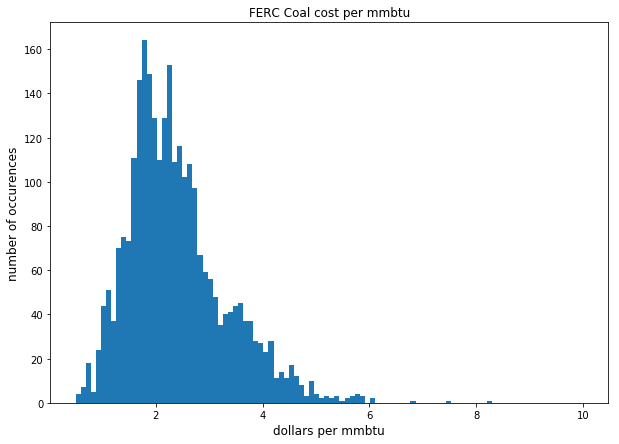

In [49]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', .5,10)

We can compare these results to EIA 923 data. We'll start by pulling the fuel receipts and costs data. When weighted by the amount of fuel delivered we see that most values lie between .5 and 7 dollars. We'll use these values to define the bounds of the main population of FERC data.

In [ ]:
fuel_rc = pd.read_sql('''SELECT fuel_quantity,energy_source, fuel_group, average_heat_content, fuel_cost, plant_id, report_date \
FROM fuel_receipts_costs_eia923''', con = pudl_engine)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


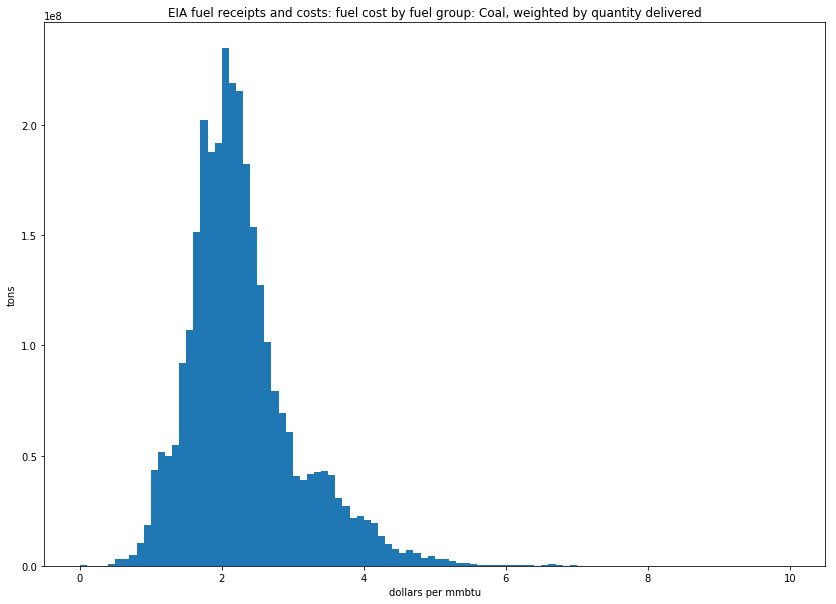

In [110]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,10),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population begins around .5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


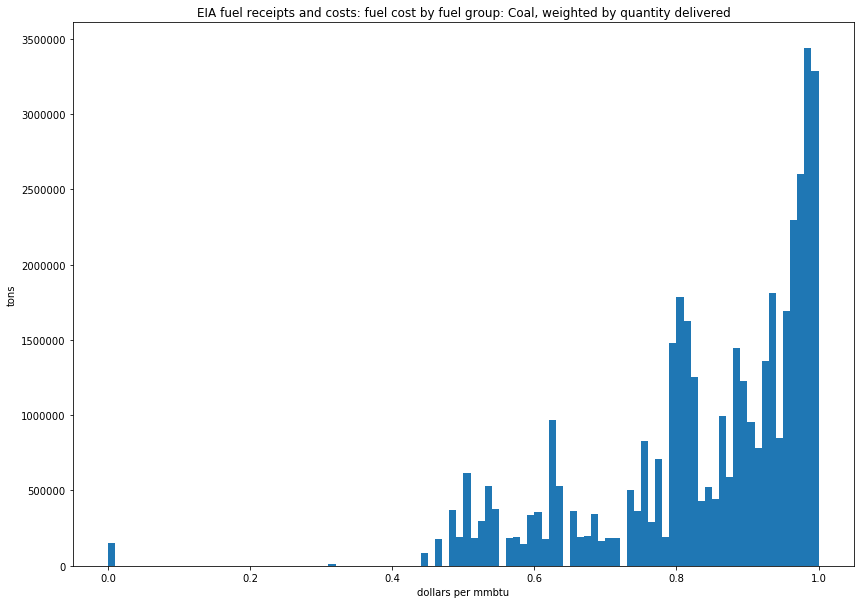

In [111]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,1),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population ends around 7.5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


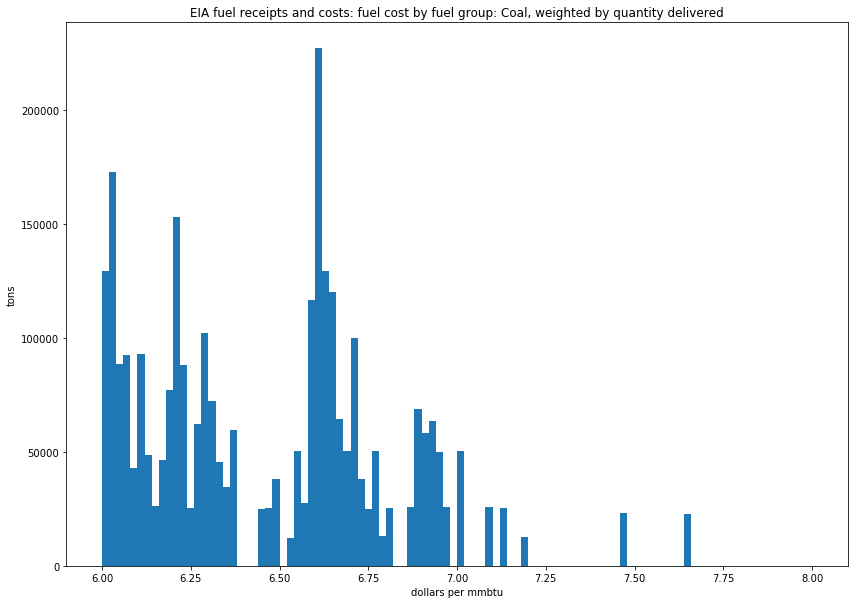

In [112]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(6,8),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

Returning our attention to the FERC data, there are two outlying populations: 
- one population around .002, which values are all associated with one utility, respondent_id 130.
- one population around 200, which is off by a factor of 100, as the utility reported cost in cents per mmbtu, rather than dollars per mmbtu.

Let's take a look at the population around .001. All of these values appear to be attributable to `respondent_id` 130.

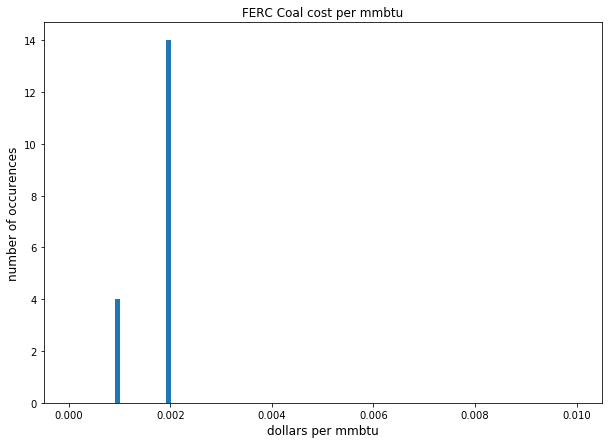

In [36]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', .00001,.01)

In [145]:
coal[(coal.fuel_cost_per_mmbtu > 0) & (coal.fuel_cost_per_mmbtu < .004)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1055,1056,130,Sooner,2007,coal,ton,3780090.0,0.017590,19.708,0.0,0.001,11.0,10.238
1058,1059,130,Muskogee,2007,coal,ton,4998369.0,0.017577,20.719,0.0,0.001,12.0,10.495
1602,1603,130,Sooner,2008,coal,ton,4510024.0,17.584000,19.349,0.0,0.001,11.0,10.299
1605,1606,130,Muskogee,2008,coal,ton,5836557.0,17.582000,20.920,0.0,0.001,18.0,10.459
2869,2870,130,Sooner,2009,coal,ton,3877888.0,17.605000,30.904,0.0,0.002,18.0,10.425
2872,2873,130,Muskogee,2009,coal,ton,5139685.0,17.630000,28.810,0.0,0.002,15.0,9.235
5032,5033,130,Sooner,2010,coal,ton,3471416.0,17.600000,33.949,0.0,0.002,20.0,10.197
5034,5035,130,Muskogee,2010,coal,ton,5046150.0,17.581000,31.196,0.0,0.002,190.0,10.939
6468,6469,130,Sooner,2011,coal,ton,4059847.0,17.601000,36.723,0.0,0.002,22.0,10.469
6470,6471,130,Muskogee,2011,coal,ton,5321781.0,17.640000,32.789,0.0,0.002,20.0,10.831


Let's take a look at the population around 200. The shape mirrors the primary distribution. These values were likely the result of a utility entering cost per mmbtu in cents rather than dollars.

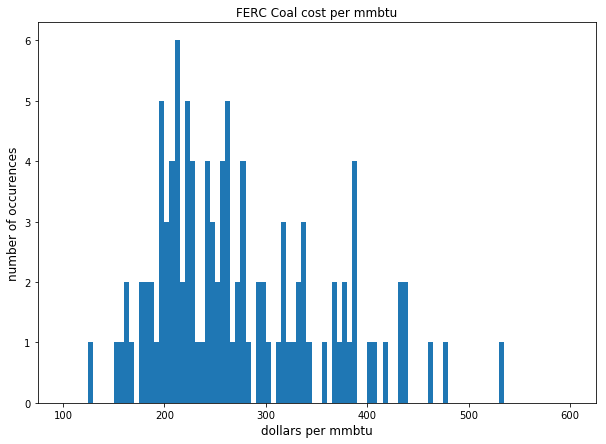

In [34]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 100,600)

There is also a cluster of values around 2000 but it is unclear what is causing these values to be off by 1000. The shape does not resemble the primary distrubtion as much as the previous population.

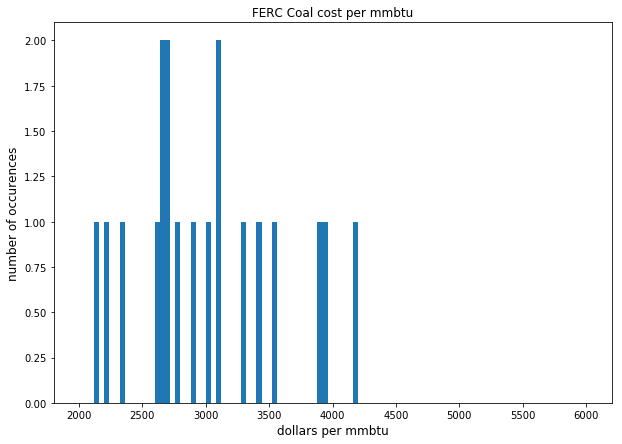

In [193]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 2000,6000)

When we apply the two cleaning functions, we see a distribution with two peaks, which appear to correspond with the price premium subbituminous higher heat content coal versus lower heat content lignite coal.

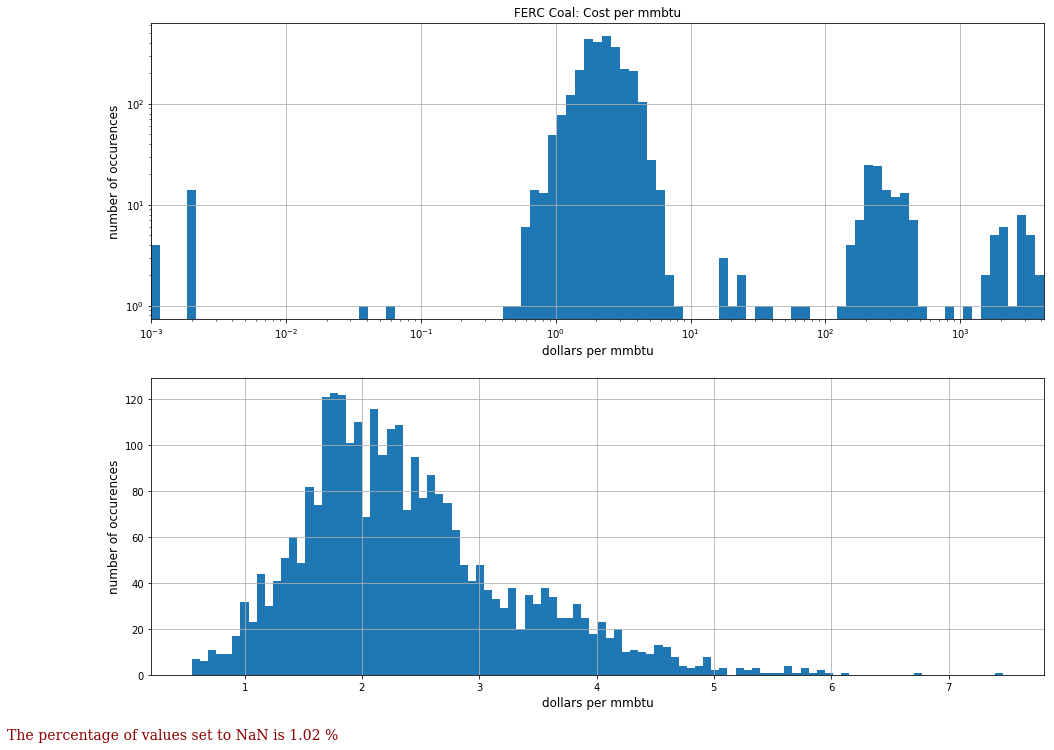

In [192]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,.001])

showfix(coal.fuel_cost_per_mmbtu,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Gas cost per mmbtu
As we turn our attention to natural gas, one expects to find the main population between roughly 2.5 and 15 dollars per mmbtu (per EIA Henry Hub data https://www.eia.gov/dnav/ng/hist/rngwhhdd.htm). One does see residential prices as high as nearly 40 dollars per mcf (in Hawaii! https://www.eia.gov/dnav/ng/ng_pri_sum_a_epg0_prs_dmcf_m.htm). Looking at the data near 5, one finds the main population begins after 2.5 and with a tail extending out to 40 dollars per mmbtu.

For natural gas pricing, EIA 923 instructions instruct respondents to "include the following pipeline charges: fuel losses, transportation reservation charges, balancing costs, and distribution system costs outside of the plant. Because these types of fees can skew the cost of the fuel per MMBtu, provide an explanation." Therefore, we're likely to see some values above the 15 dollars per mmbtu Henry Hub maximum, although we shouldn't see consistently high pricing like we see in the residential data.

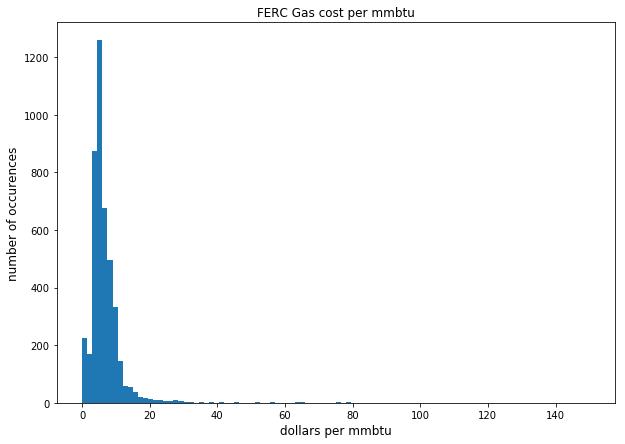

In [213]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 0,150)

When we look at EIA fuel cost data weighted by quantity delivered we see a clear drop off after 15 dollars per mcf and a tail of values going out to roughly 35.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


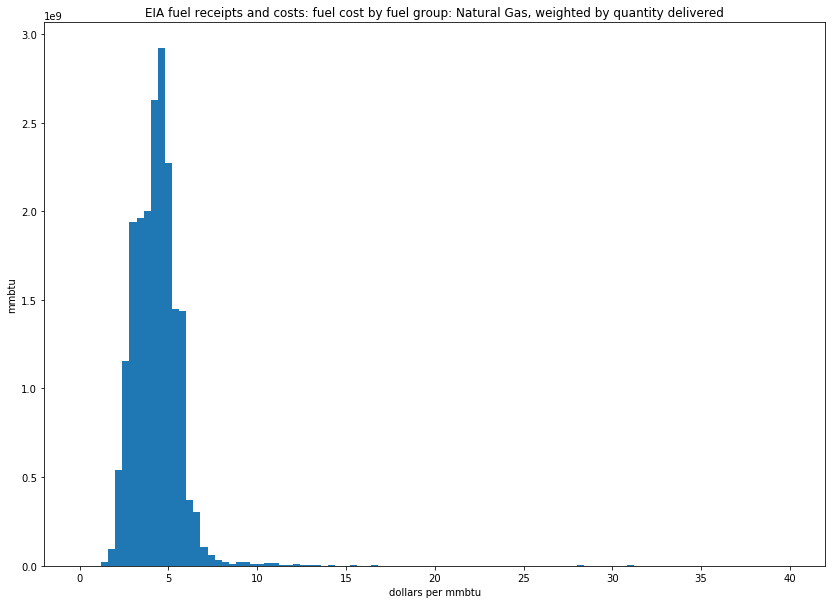

In [134]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mmbtu')

This tail is more apparent when fuel costs are not weighted by quantity delivered.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


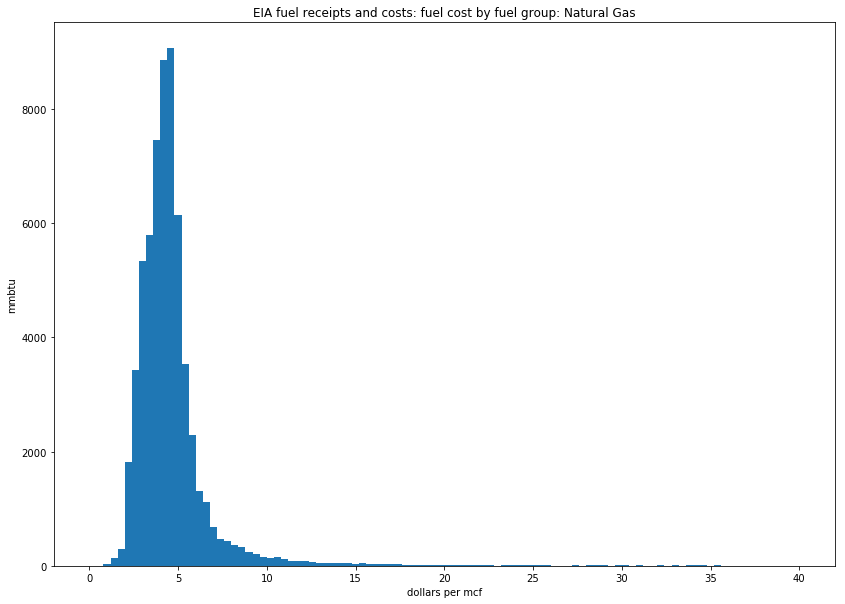

In [123]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

The population appears to begin around 1 - it's difficult to say exactly where to draw the line.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


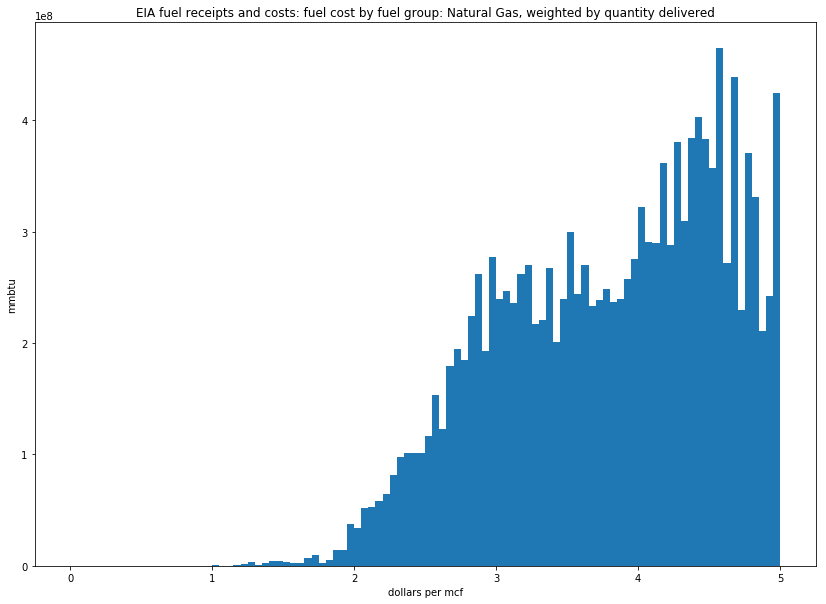

In [114]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,5),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

Zooming in.

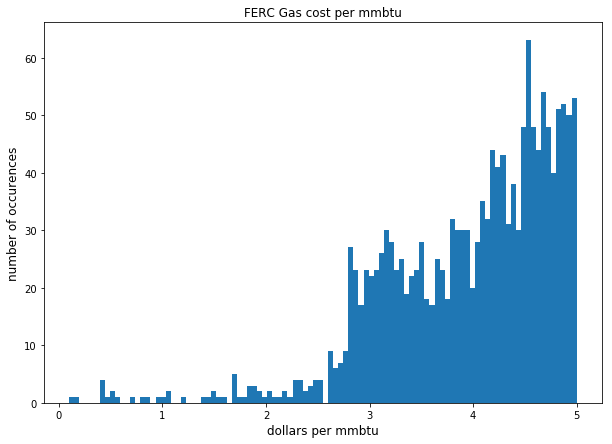

In [295]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', .1,5)

The distribution begins to drop off considerable after 12 dollars per mmbtu.

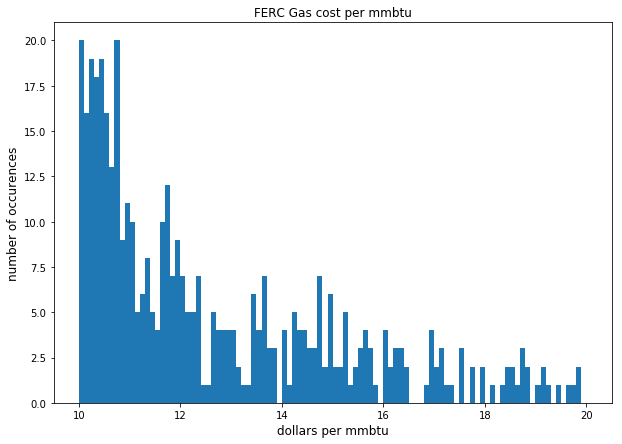

In [68]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 10,20)

The tail continues and drops off even further after roughly 50 dollars per mmbtu.

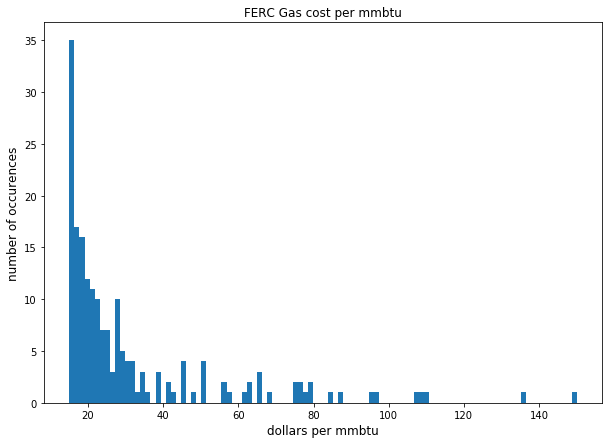

In [69]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 15,150)

When weighted by quantity burned, we see a much tighter distribution and values don't range past 35 dollars per mmbtu.

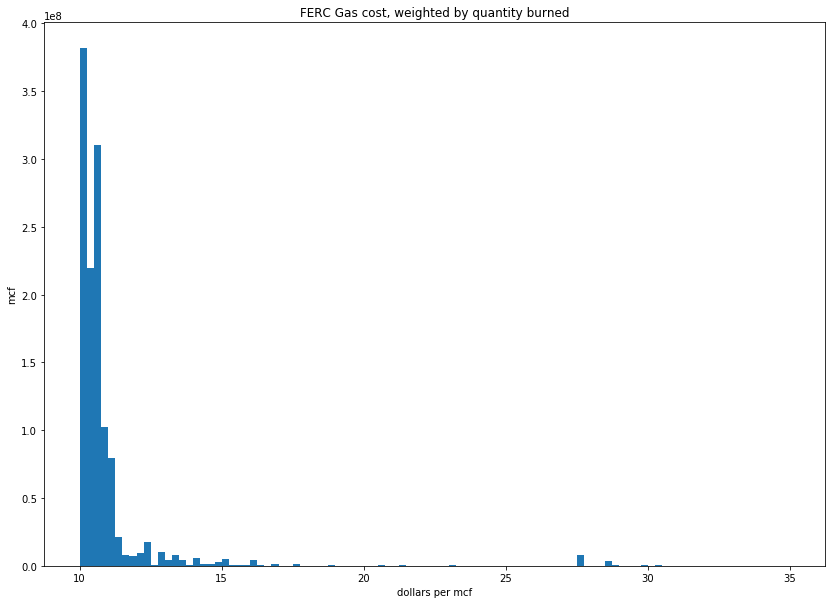

In [153]:
plt.figure(figsize=(14,10))
plt.hist(gas.fuel_cost_per_mmbtu,range=(10,35),weights=gas.fuel_qty_burned,bins=100)
plt.title('FERC Gas cost, weighted by quantity burned')
plt.ylabel('mcf')
plt.xlabel('dollars per mcf')

The second population stretches from just after 250 to 4000 - off by a factor of 100.  These values were likely the result of a utility entering cost per mmbtu in cents rather than dollars.

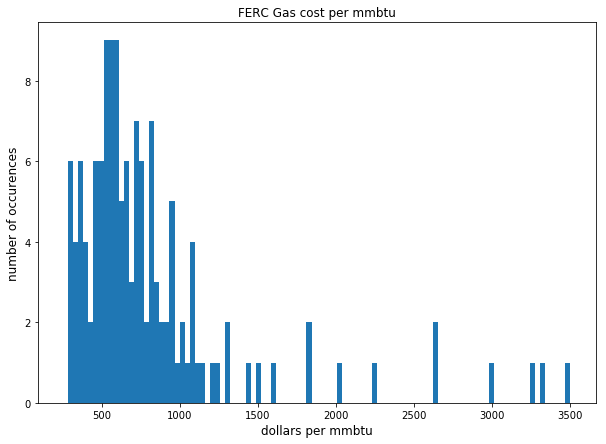

In [168]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 250,3500)

The third population is between .002 and .0175 - off by a factor of 1000. These values are likely the result of the utility entering the cost in mmbtu per cf rather than mmbtu per mcf.

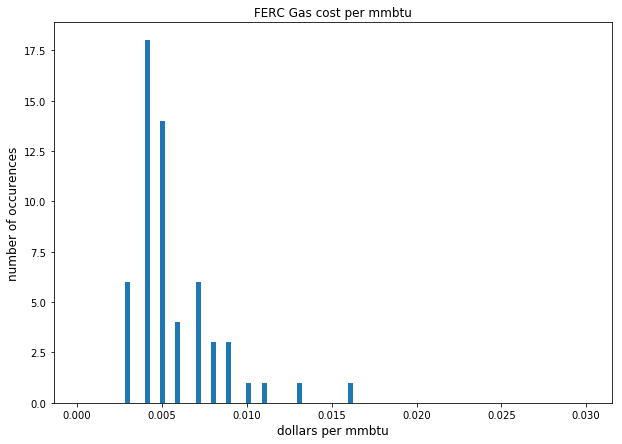

In [169]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu',.0001,.03)

With the except of two records, all of these values are also attributable to utility `respondent_id` 130.

In [149]:
gas[(gas.fuel_cost_per_mmbtu > .0001) & (gas.fuel_cost_per_mmbtu < .02)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
943,944,182,A. Mullergren,2007,gas,mcf,1572.0,1.046000,9.740,9.740,0.013,-25.0,0.000000
1051,1052,130,Horseshoe Lake,2007,gas,mcf,12516345.0,1.037000,6.874,0.000,0.007,78.0,11.690000
1053,1054,130,Seminole,2007,gas,mcf,38693460.0,1.037000,7.232,0.000,0.007,82.0,11.809000
1057,1058,130,Enid,2007,gas,mcf,38850.0,1.037000,6.386,0.000,0.006,151.0,23.672000
1059,1060,130,Muskogee,2007,gas,mcf,3682025.0,1.037000,6.247,0.000,0.006,69.0,11.173000
1060,1061,130,Mustang,2007,gas,mcf,9915051.0,1.037000,6.950,0.000,0.007,72.0,10.677000
1062,1063,130,Mcclain,2007,gas,mcf,18188683.0,1.037000,6.732,0.000,0.007,46.0,7.070000
1600,1601,130,Horseshoe Lake,2008,gas,mcf,9854405.0,1.037000,9.815,0.000,0.009,108.0,11.407000
1601,1602,130,Seminole,2008,gas,mcf,37163017.0,1.037000,8.840,0.000,0.008,98.0,11.594000
1604,1605,130,Enid,2008,gas,mcf,4003.0,1.037000,10.295,0.000,0.010,206.0,20.135000


Applying the two cleaning functions, we see a distribution peaking around 5 dollars per mmbtu with a tail out to 35 dollars per mmbtu.

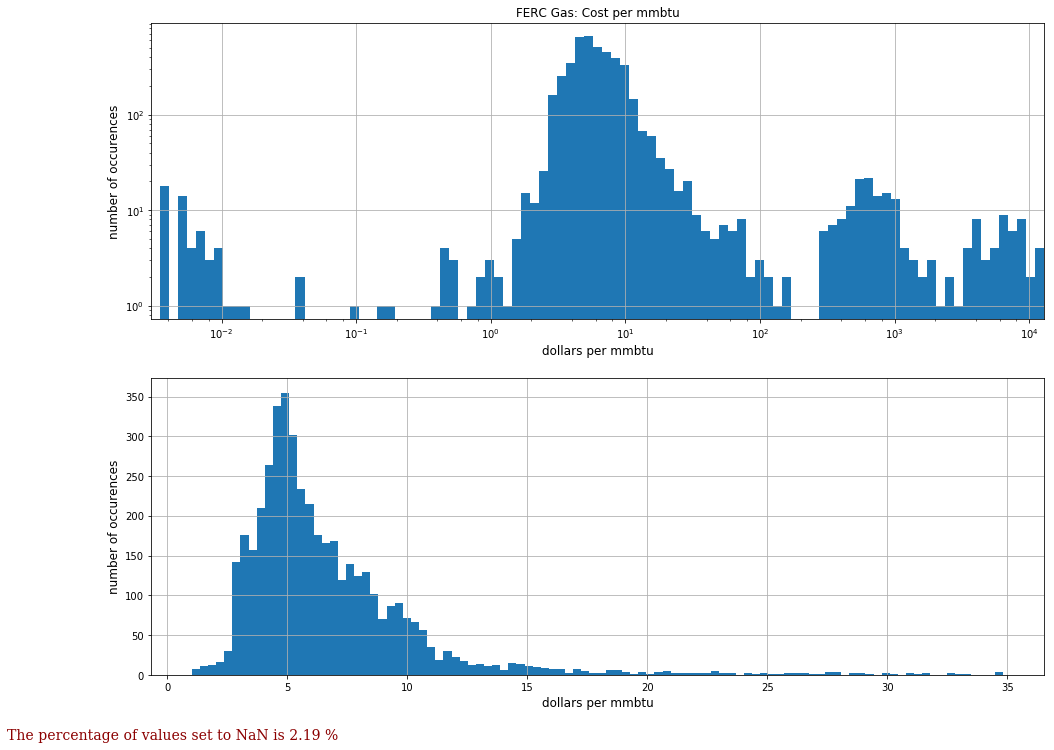

In [136]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,1,35,[.01,1000])

showfix(to_fix_cost_per_mmbtu_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')